In [1]:
from transmitter import *
from reciever import *
import numpy as np
from scipy.signal import chirp, spectrogram
import simpleaudio as sa
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [2]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21             # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}


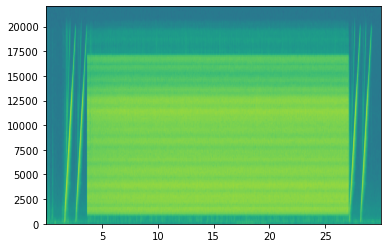

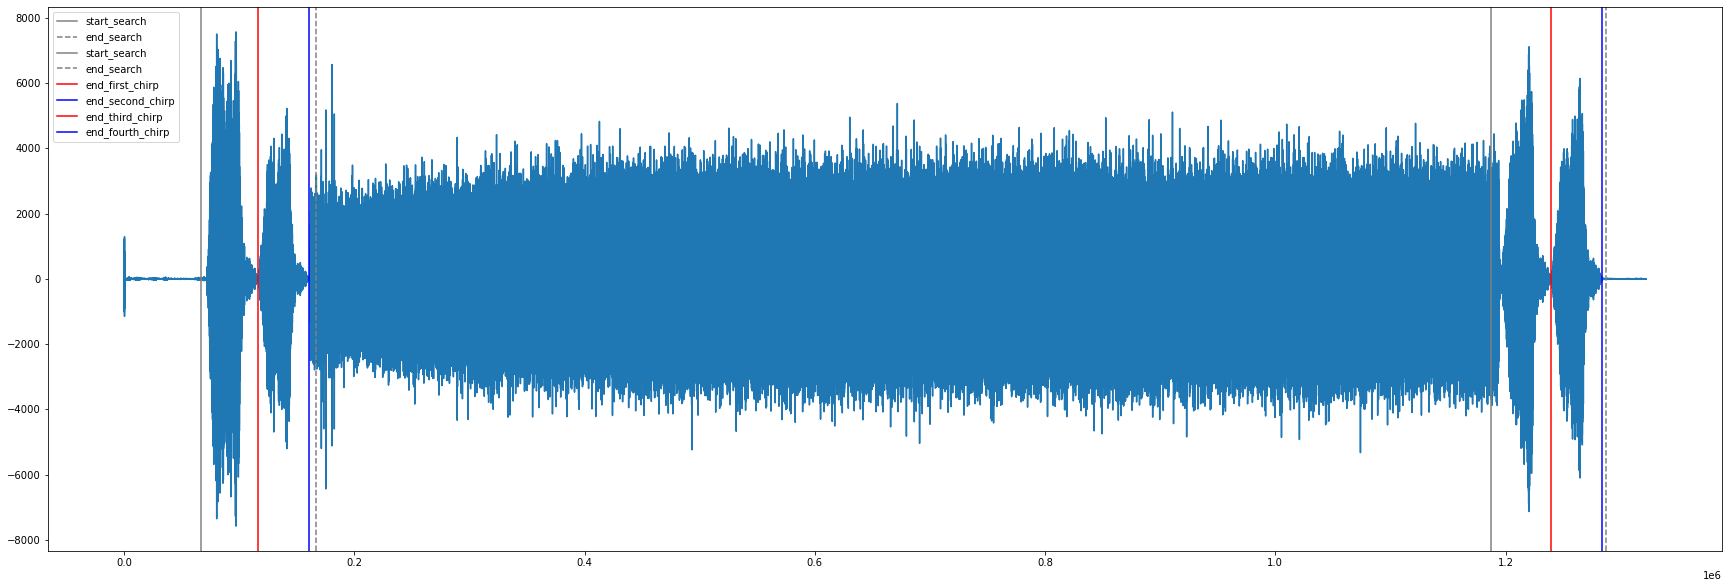

"norm_aud =  auds/np.max(auds)\npeka = scipy.signal.find_peaks(norm_aud, 0.5)[0]\nstart_search1 = peka[0]-10000\nend_search1 = start_search1 + 100000\nend_search2 = peka[-1]+20000\nstart_search2 = end_search2 - 100000\n\nplt.figure(figsize = (30, 10))\nplt.plot(norm_aud)\nplt.axvline(x = start_search1 , color = 'r')\nplt.axvline(x = end_search1 , color = 'r')\nplt.axvline(x = start_search2 , color = 'r')\nplt.axvline(x = end_search2 , color = 'r')\nplt.show()"

In [3]:
Fs, auds = read('Group_8_rec.wav')

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(auds, Fs=fs)
plt.show()

chirps = chirpEnds(auds, graph_display=True)



'''norm_aud =  auds/np.max(auds)
peka = scipy.signal.find_peaks(norm_aud, 0.5)[0]
start_search1 = peka[0]-10000
end_search1 = start_search1 + 100000
end_search2 = peka[-1]+20000
start_search2 = end_search2 - 100000

plt.figure(figsize = (30, 10))
plt.plot(norm_aud)
plt.axvline(x = start_search1 , color = 'r')
plt.axvline(x = end_search1 , color = 'r')
plt.axvline(x = start_search2 , color = 'r')
plt.axvline(x = end_search2 , color = 'r')
plt.show()'''

In [14]:

chirp_time = 1
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=250, f1=20000, t1=chirp_time, method='linear')
note = note*np.hamming(len(note))

#delay_guess = np.abs(np.correlate(auds, note, mode='full'))

delay_guess1 = np.abs(np.correlate(auds[start_search1:end_search1], note, mode='full'))
delay_guess2 = np.abs(np.correlate(auds[start_search2:end_search2], note, mode='full'))


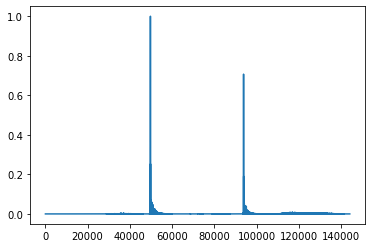

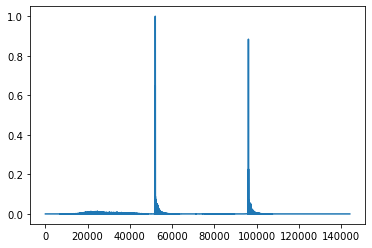

start: (array([49711, 93813]), {'peak_heights': array([1.       , 0.7070294])})
end: (array([52008, 96110]), {'peak_heights': array([1.        , 0.88385577])})
44102 44102


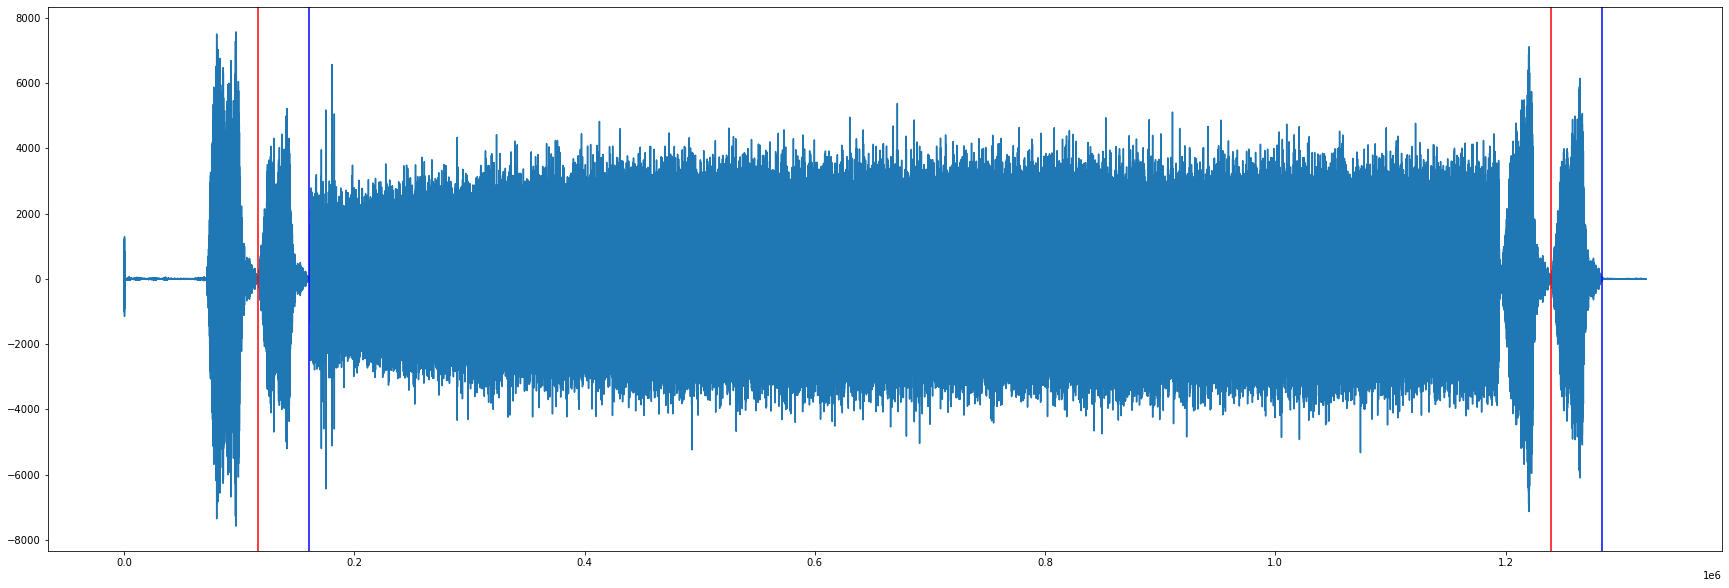

In [18]:
delay_guess_norm1 = delay_guess1/np.max(delay_guess1)
delay_guess_norm2 = delay_guess2/np.max(delay_guess2)

plt.plot(delay_guess_norm1)
plt.show()
plt.plot(delay_guess_norm2)
plt.show()

peaks_1 = scipy.signal.find_peaks(delay_guess_norm1, 0.5, distance = 3000)
peaks_2 = scipy.signal.find_peaks(delay_guess_norm2, 0.5, distance = 3000)
print('start:',peaks_1)
print('end:',peaks_2)

end_first_chirp = peaks_1[0][0]+start_search1
end_second_chirp = peaks_1[0][1]+start_search1
end_third_chirp = peaks_2[0][0]+start_search2
end_fourth_chirp = peaks_2[0][1]+start_search2
delayed_start = end_second_chirp + 1500 + 1
delayed_end = end_third_chirp - 44100 - 1500 - 1
print(end_second_chirp-end_first_chirp, end_fourth_chirp-end_third_chirp)

plt.figure(figsize = (30, 10))
plt.plot(auds)
plt.axvline(x = end_first_chirp , color = 'r')
plt.axvline(x = end_second_chirp , color = 'b')
plt.axvline(x = end_third_chirp , color = 'r')
plt.axvline(x = end_fourth_chirp , color = 'b')

plt.show()


In [50]:
def channelEstimate(four_known_symbols, ofdm):

    even_one = four_known_symbols[:ofdm.N+ofdm.CP]
    odd_one = four_known_symbols[ofdm.N+ofdm.CP:2*(ofdm.N+ofdm.CP)]
    even_two = four_known_symbols[2*(ofdm.N+ofdm.CP):3*(ofdm.N+ofdm.CP)]
    odd_two = four_known_symbols[3*(ofdm.N+ofdm.CP):4*(ofdm.N+ofdm.CP)]
    odd_index = np.arange(0,741,2)
    even_index=np.arange(1,741,2)

    exported_coding = np.loadtxt('preamble_qpsk_symbols.csv', delimiter=',',dtype=complex)
    exported_coding *= 1.41421356474619

    hes_e1 = (fft(even_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o1 = (fft(odd_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_e2 = (fft(even_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o2 = (fft(odd_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    
    hest_one = np.zeros(741, dtype='complex')
    hest_one[even_index] = hes_e1[even_index]
    hest_one[odd_index] = hes_o1[odd_index]

    hest_two = np.zeros(741, dtype='complex')
    hest_two[even_index] = hes_e2[even_index]
    hest_two[odd_index] = hes_o2[odd_index]


    return hest_one, hest_two


def chanest_padd(hest,ofdm):
    full_size = np.ones(ofdm.N, dtype='complex')
    full_size[49:790] = hest
    return full_size

def error_(data1,data_correct):
    errs = 0
    for i in range(len(data_correct)):
        if data_correct[i] != data1[i]:
            errs += 1
    return 100*errs/len(data_correct)

def errorss(decod):
    code_length = len(bit_array)
    error_by_block = []
    n=720*2
    for i in range(0,code_length,n):
        error_by_block.append(error_(decod[i:i+n],bit_array[i:i+n]))
    return error_by_block


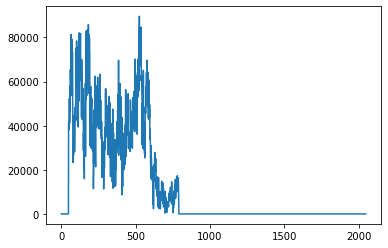

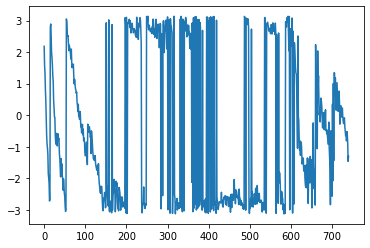

In [49]:
ayy,bee = channelEstimate(auds[delayed_start:delayed_start+2304*4], ofdm)

plt.plot(abs(chanest_padd(ayy,ofdm)))
plt.show()
plt.plot(np.angle(ayy))
plt.show()

9236 1194010 1184774
(619200,)
618192
(618192,)


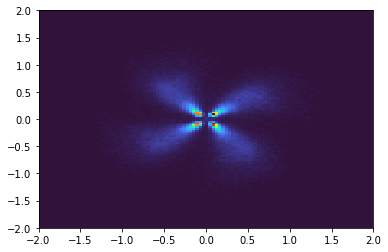

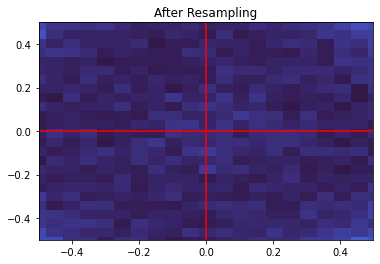

Text(0.5, 1.0, 'After Resampling - No Window')

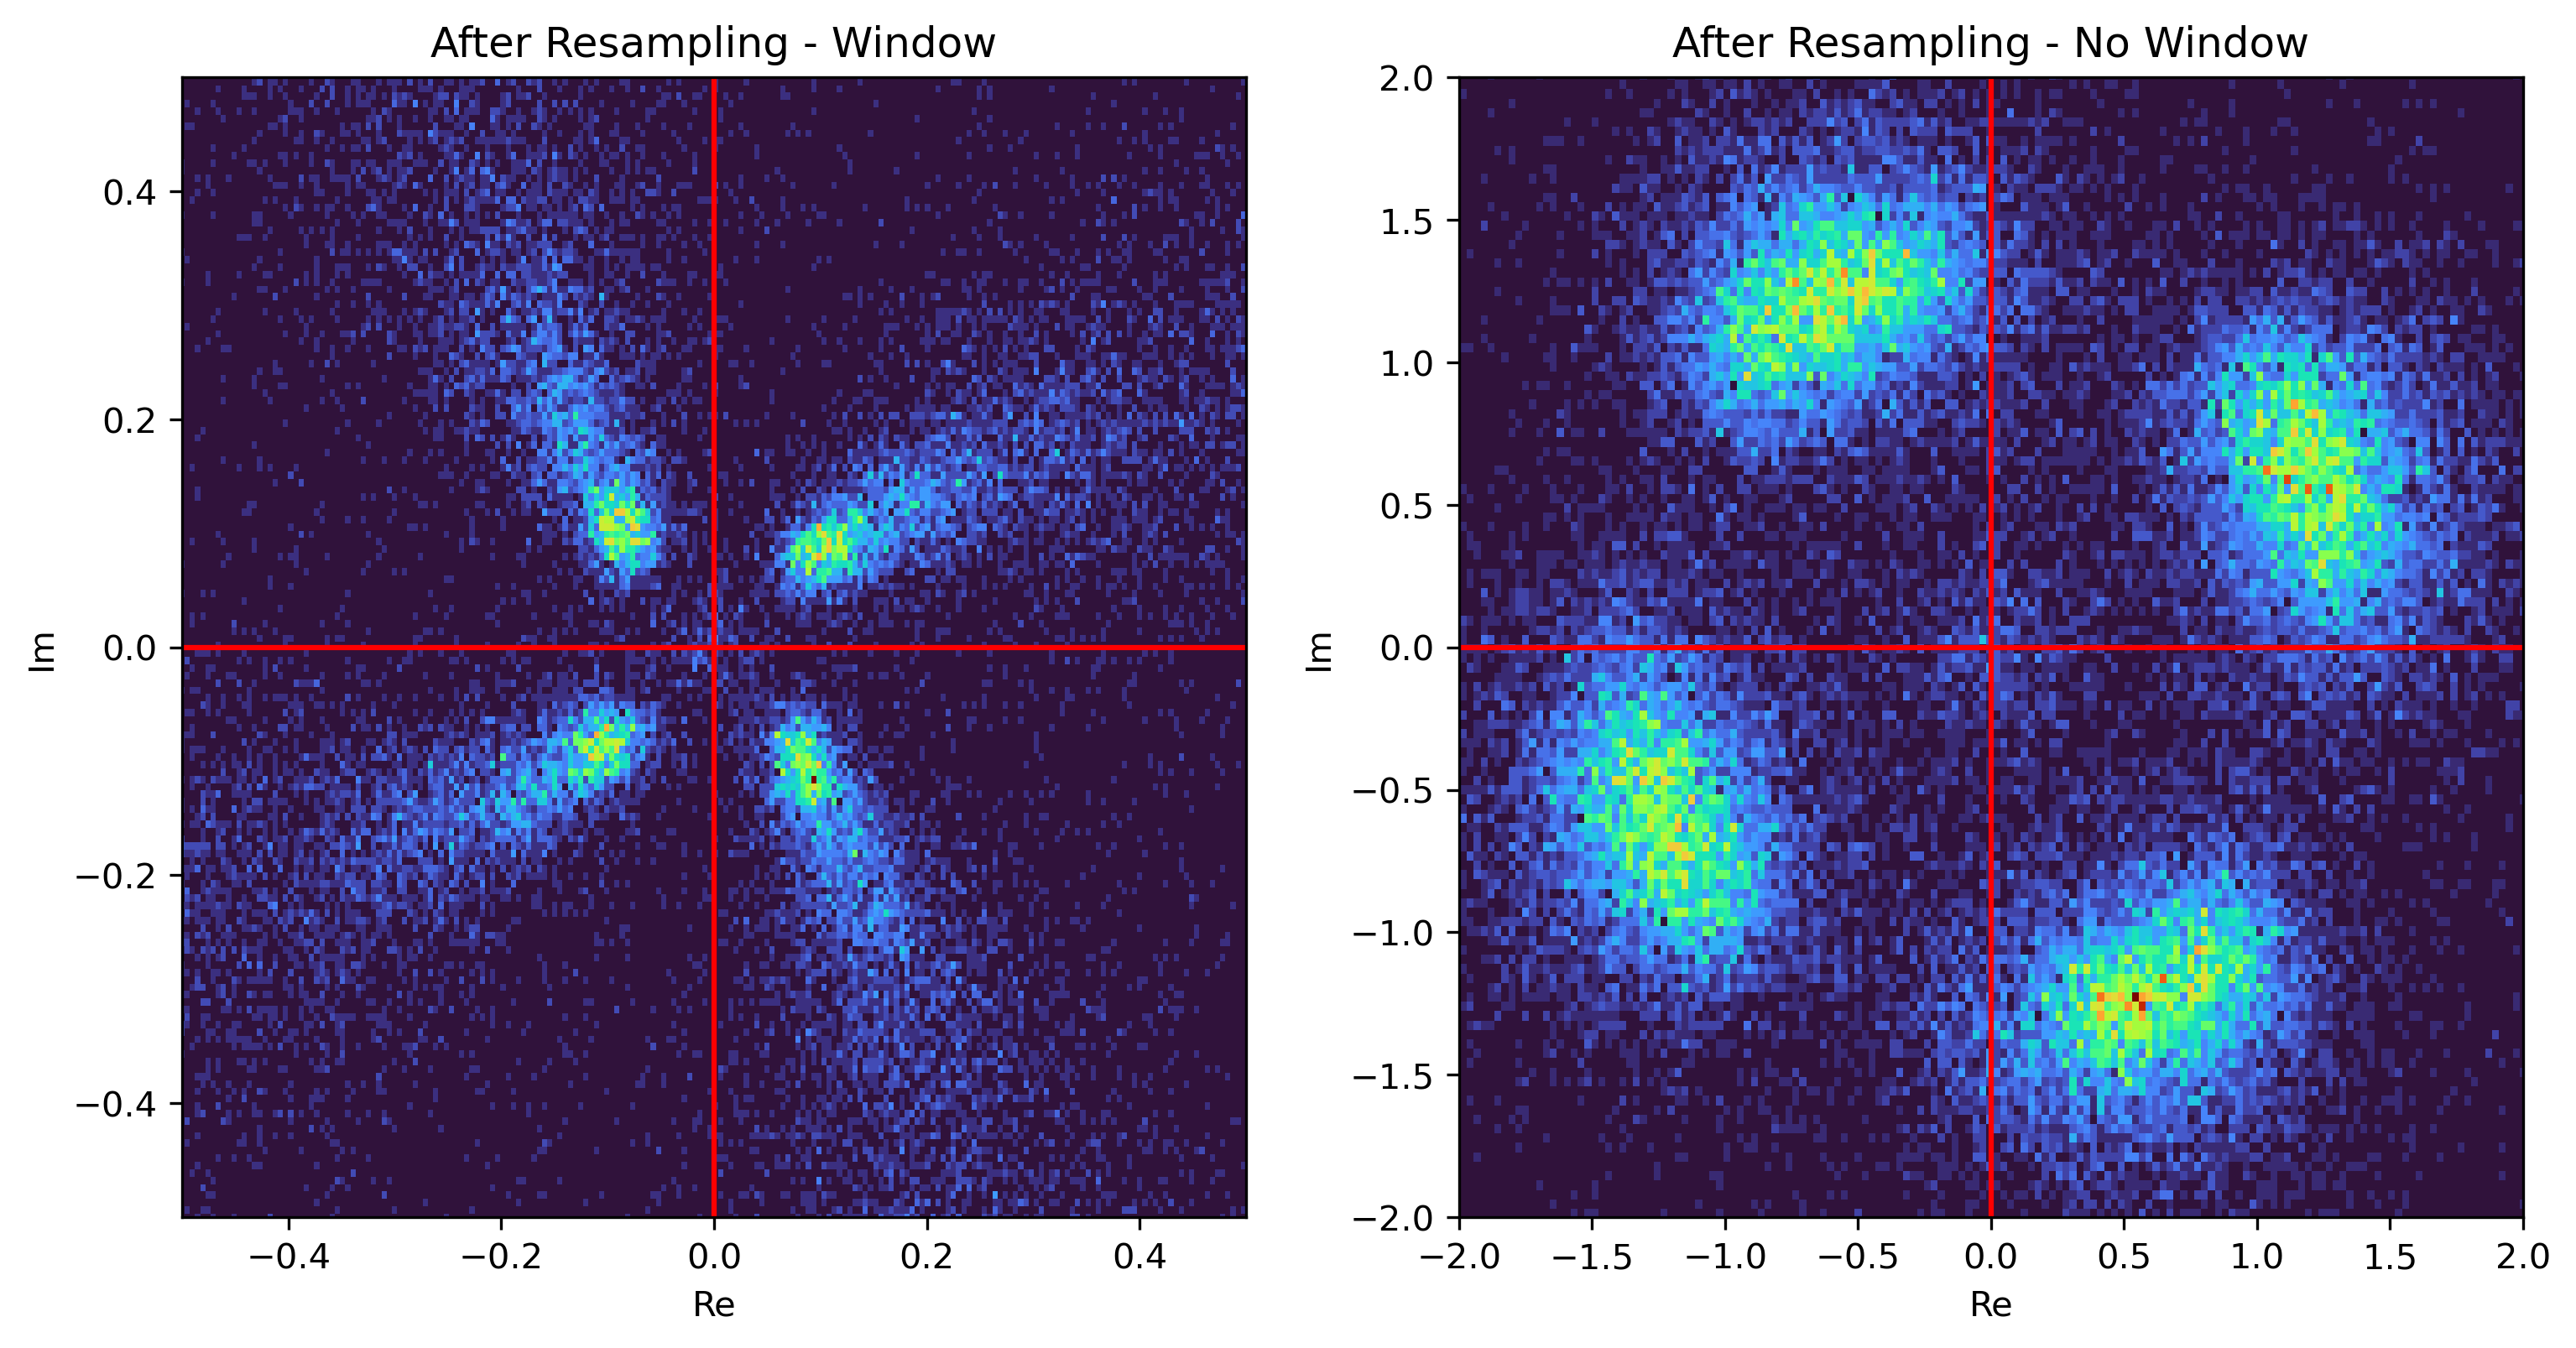

In [182]:
data_start  = delayed_start+2304*4
delayed_end_snc = delayed_end - 2304*4
num_symbs_guess = round((delayed_end-data_start)/2304)
new_end = data_start + num_symbs_guess*2304
print(new_end-delayed_end_snc, new_end, delayed_end_snc)

#plt.plot(auds[new_end-1000:new_end+1000])
#plt.axvline(x = 1000 , color = 'r')
#plt.show()

of=5
fo=0
win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('hamming', win_len)
resampled_aud3 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start)
resampled_aud4 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], new_end-data_start, window = win)

decoded, symbols_rec = standard_deconstructor(resampled_aud4, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, ldpc_encoded = False)
decoded2, symbols_rec2 = standard_deconstructor(resampled_aud3, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True)



plt.hist2d(np.real(symbols_rec.flatten()), np.imag(symbols_rec.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.show()

plt.hist2d(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
plt.axvline(x = 0 , color = 'r')
plt.axhline(y = 0 , color = 'r')
plt.xlim(-0.5,0.5)
plt.ylim(-0.5,0.5)
plt.title('After Resampling')
plt.show()

fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 300)

axs[0].hist2d(np.real(symbols_rec[-60:-2].flatten()), np.imag(symbols_rec[-60:-2].flatten()), bins=(4000, 4000),cmap=plt.cm.turbo)
axs[0].axvline(x = 0 , color = 'r')
axs[0].axhline(y = 0 , color = 'r')
axs[0].set_xlim(-0.5,0.5)
axs[0].set_ylim(-0.5,0.5)
axs[0].set_xlabel("Re")
axs[0].set_ylabel("Im")
axs[0].set_title("After Resampling - Window")

axs[1].hist2d(np.real(symbols_rec2[-60:-2].flatten()), np.imag(symbols_rec2[-60:-2].flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
axs[1].axvline(x = 0 , color = 'r')
axs[1].axhline(y = 0 , color = 'r')
axs[1].set_xlim(-2,2)
axs[1].set_ylim(-2,2)
axs[1].set_xlabel("Re")
axs[1].set_ylabel("Im")
axs[1].set_title("After Resampling - No Window")


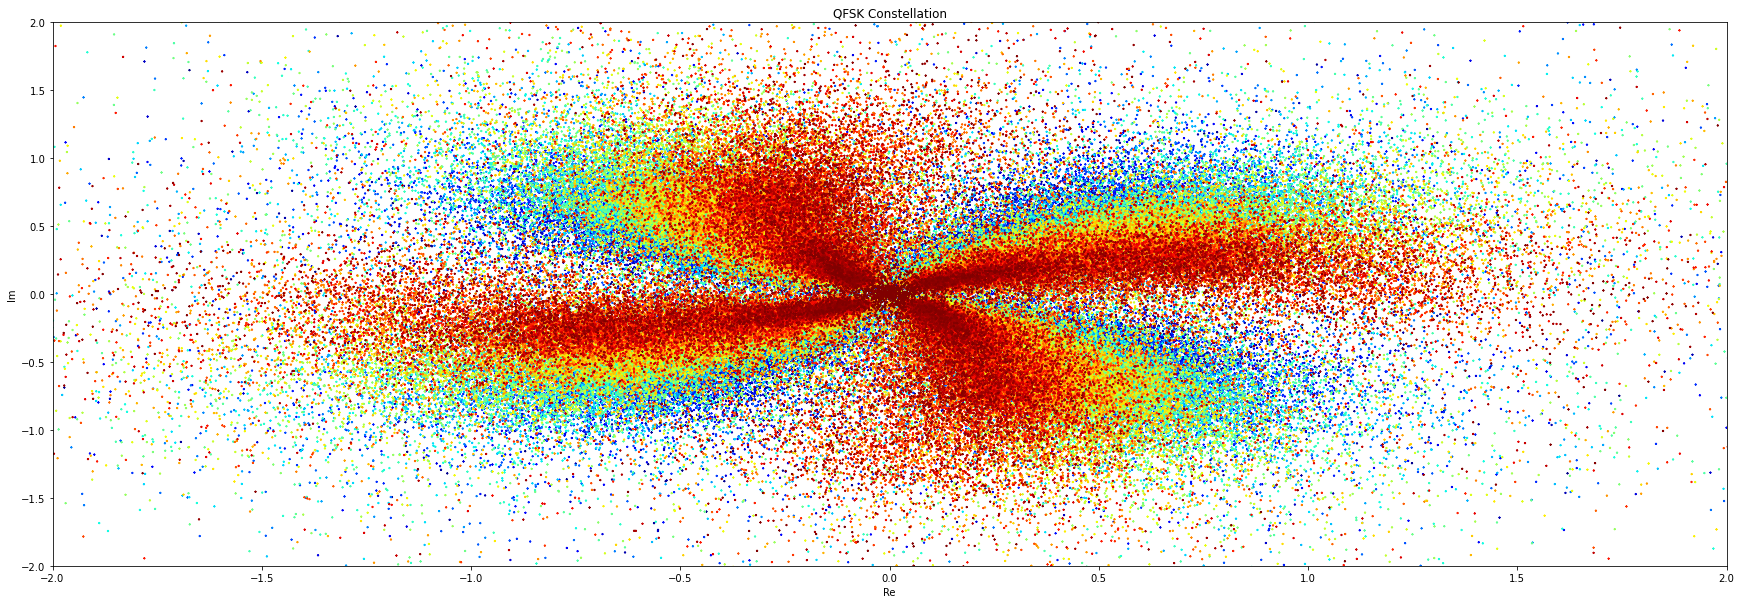

"plt.scatter(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), marker='x', cmap=plt.cm.turbo)\nplt.xlim(-2,2)\nplt.ylim(-2,2)"

In [178]:



plt.figure(figsize = (30, 10))
x = np.real(symbols_rec).flatten()
y = np.imag(symbols_rec).flatten()
colors = plt.cm.jet(np.linspace(0, 1, len(y)))
plt.scatter(x, y, color=colors, marker='x',s=2)
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.title('QFSK Constellation')
plt.xlabel('Re')
plt.ylabel('Im')
plt.show()

'''plt.scatter(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), marker='x', cmap=plt.cm.turbo)
plt.xlim(-2,2)
plt.ylim(-2,2)'''


In [130]:
col

[(0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 0.23217, 1.0),
 (0.18995, 0.07176, 

In [92]:
header = decoded2[:7*8*3]
header[:7*8], header[7*8:7*8*2], header[7*8*2:7*8*3]

print(''.join([str(i) for i in header[:7*8]]))
print(''.join([str(i) for i in header[7*8:7*8*2]]))
print(''.join([str(i) for i in header[7*8*2:7*8*3]]))



01101010011100000110011100000000000001001010101001001000
01101010011100000110011100000000000001001010101001001000
01101010011100000110011100000000000001001010101001001000


In [114]:
def decode_header(bits_in):
    lst = [str(i) for i in bits_in[:7*8*3]]
    out = [int(''.join(map(str, lst[i:i+8])),2) for i in range(0, len(lst), 8)]
    bytes_in = bytearray(out)

    verified_header=b''
    for i in range(7):
        if bytes_in[i] == bytes_in[i+7] or bytes_in[i] == bytes_in[i+14]:
            verified_header += bytes_in[i].to_bytes(1, byteorder='big')
        elif bytes_in[i+7] == bytes_in[i+14]:
            verified_header += bytes_in[i+7].to_bytes(1, byteorder='big')
        else:
            raise ValueError("There are too many errors in the input header")
    filetype = '.' + verified_header[0:4].strip(b'\x00').decode('utf-8')
    filesize = int.from_bytes(verified_header[4:7], 'big')
    return filetype, filesize


lst = [str(i) for i in decoded2[:7*8*3]]
out = [int(''.join(map(str, lst[i:i+8])),2) for i in range(0, len(lst), 8)]
bytearray(out), decode_header(bytearray(out))




(bytearray(b'jpg\x00\x04\xaaHjpg\x00\x04\xaaHjpg\x00\x04\xaaH'),
 ('.jpg', 305736))

In [179]:
data = decoded2[7*8*3:305736*8]
str_data = [str(i) for i in data]
bytes_int = [int(''.join(map(str, str_data[i:i+8])),2) for i in range(0, len(str_data), 8)]

with open("trial_group_8.jpg", 'wb') as f:
    f.write(bytearray(bytes_int))